In [1]:
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

# Building the joint prior 

In this repository there exists code to compute the conditional priors $p(\chi_\mathrm{eff}|q)$ and $p(\chi_q|q)$ (functions `chi_effective_prior_from_isotropic_spins` and `chi_p_prior_from_isotropic_spins`, respectively) on $\chi_\mathrm{eff}$ and $\chi_p$ corresponding to uniform and isotropic component spin priors. Each of these priors have been marginalized over all other spin degrees of freedom.

In some circumstances, though, we might want the *joint* prior $p(\chi_\mathrm{eff},\chi_p|q)$ acting on the two effective spin parameters. Although we were able to derive closed-form expressions for $p(\chi_\mathrm{eff}|q)$ and $p(\chi_q|q)$, I personally lack the will-power and/or attention span to derive an analytic expression for $p(\chi_\mathrm{eff},\chi_p|q)$. Instead, let's build a function to do this numerically.

First, note that the joint prior on $\chi_\mathrm{eff}$ and $\chi_p$ is *weird*. Demonstrate this by drawing random component spins, computing the corresponding effective spins, and plotting the resulting density.

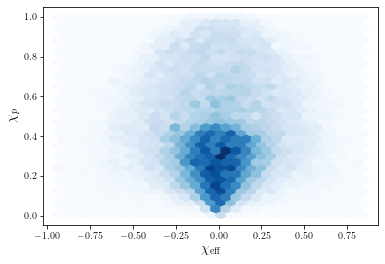

In [2]:
def chi_p(a1,a2,cost1,cost2,q):
    
    sint1 = np.sqrt(1.-cost1**2)
    sint2 = np.sqrt(1.-cost2**2)
    
    return np.maximum(a1*sint1,((3.+4.*q)/(4.+3.*q))*q*a2*sint2)

def chi_eff(a1,a2,cost1,cost2,q):
    
    return (a1*cost1 + q*a2*cost2)/(1.+q)

# Choose some fixed mass ratio
q = 0.5

# Draw random component spins and compute effective parameters
ndraws = 30000
random_a1s = np.random.random(ndraws)
random_a2s = np.random.random(ndraws)
random_cost1s = 2.*np.random.random(ndraws)-1.
random_cost2s = 2.*np.random.random(ndraws)-1.

# Plot!
random_chi_effs = chi_eff(random_a1s,random_a2s,random_cost1s,random_cost2s,q)
random_chi_ps = chi_p(random_a1s,random_a2s,random_cost1s,random_cost2s,q)

fig,ax =  plt.subplots()
ax.hexbin(random_chi_effs,random_chi_ps,cmap='Blues',gridsize=30)
ax.set_xlabel('$\chi_\mathrm{eff}$',fontsize=14)
ax.set_ylabel('$\chi_p$',fontsize=14)
plt.show()

There are a few visible features we need to worry about.
1. First, the prior distribution comes to a sharp point at $\chi_\mathrm{eff} = \chi_p = 0$; this is related to the fact that the marginal $p(\chi_\mathrm{eff}|q)$ is quite sharply peaked about the origin (see `Demo.ipynb`)
2. The concentration about $\chi_\mathrm{eff} = 0$ also implies that vanishingly few of our prior draws occur in the distant wings of the joint prior, at very negative or very positive  $\chi_\mathrm{eff}$.
3. In the vertical direction, we can see the same sharp drop and extended plateau as seen in the marginal $\chi_p$ prior in `Demo.ipynb`

Naively, we could just draw a bunch of prior samples and form a KDE over this space. The first two features listed above, though, make this extremely difficult. The extreme narrowness of $p(\chi_\mathrm{eff},\chi_p|q)$ near the origin means we must use an extremely small KDE bandwidth to accurately capture this behavior, but such a small bandwidth will accentuate sampling fluctuations elsewhere. Meanwhile, the fact that very few samples occur at very positive or very negative $\chi_\mathrm{eff}$ means that we will need to perform a vast number of draws (like, many millions) if we wish to accurately estimate the prior on posterior samples falling in these areas.

Recall that this prior remains *conditional* on $q$, and so we can't just build a single KDE (in which case we might tolerate having to perform a vast number of draws and slow KDE evaluation), but will need to build a new estimator every time we consider a different mass ratio.

Instead, let's leverage our knowledge of the marginal prior $p(\chi_\mathrm{eff}|q)$ and factor the joint prior as

\begin{equation}
p(\chi_\mathrm{eff},\chi_p|q) = p(\chi_p|\chi_\mathrm{eff},q) p(\chi_\mathrm{eff},q),
\end{equation}

so that we only have to worry about numerically constructing the one-dimensional distribution $p(\chi_p|\chi_\mathrm{eff},q)$.

Given $\chi_\mathrm{eff}$ and $q$, we will repeatedly draw $\{a_1,a_2,\cos t_1,\cos t_2\}$ consistent with $\chi_\mathrm{eff}$, and then construct the resulting distribution over $\chi_p$. In particular, we will regard 

\begin{equation}
\cos t_1 = \frac{(1+q)\chi_\mathrm{eff} - q a_2 \cos t_2}{a_1}
\end{equation}

as a function of the $\chi_\mathrm{eff}$ and the three other component spin parameters. In making this choice, though, we are *really* drawing from a slice through

\begin{equation}
\frac{dP}{d a_1 da_2 d\chi_\mathrm{eff} d\cos t_2 } = \frac{dP}{d a_1 da_2 d \cos t_1 d\cos t_2} \frac{\partial \cos t_1}{\partial \chi_\mathrm{eff}}.
\end{equation}

Thus, in order to have properly sampled from the underlying uniform and isotropic distribution $dP/d a_1 da_2 d \cos t_1 d\cos t_2$, we will need to remember to divide out the Jacobian weights $\partial \cos t_1/\partial \chi_\mathrm{eff} = a_1/(1+q)$.

Let's try this in the following cell:

In [3]:
# Fix some value for chi_eff and q
# Feel free to change these!
aMax = 1.
Xeff = 0.2
q = 0.7

# Draw random spin magnitudes.
# Note that, given a fixed chi_eff, a1 can be no larger than (1+q)*chi_eff,
# and a2 can be no larger than (1+q)*chi_eff/q
ndraws = 100000
a1 = np.random.random(ndraws)*aMax
a2 = np.random.random(ndraws)*aMax

# Draw random tilts for spin 2
cost2 = 2.*np.random.random(ndraws)-1.

# Finally, given our conditional value for chi_eff, we can solve for cost1
# Note, though, that we still must require that the implied value of cost1 be *physical*
cost1 = (Xeff*(1.+q) - q*a2*cost2)/a1  

# While any cost1 values remain unphysical, redraw a1, a2, and cost2, and recompute
# Repeat as necessary
while np.any(cost1<-1) or np.any(cost1>1):   
    to_replace = np.where((cost1<-1) | (cost1>1))[0]   
    a1[to_replace] = np.random.random(to_replace.size)*aMax
    a2[to_replace] = np.random.random(to_replace.size)*aMax
    cost2[to_replace] = 2.*np.random.random(to_replace.size)-1.    
    cost1 = (Xeff*(1.+q) - q*a2*cost2)/a1   
        
Xp_draws = chi_p(a1,a2,cost1,cost2,q)
jacobian_weights = (1.+q)/a1

For comparison, let's also take a brute-force approach, drawing truly random component spins and saving those whose $\chi_\mathrm{eff}$ are "close to" the conditioned $\chi_\mathrm{eff}$ value specified above. This can take a while, depending on the values of $q$ and $\chi_\mathrm{eff}$ we've chosen...

In [4]:
test_a1s = np.array([])
test_a2s = np.array([])
test_cost1s = np.array([])
test_cost2s = np.array([])

while test_a1s.size<30000:
    
    test_a1 = np.random.random()*aMax
    test_a2 = np.random.random()*aMax
    test_cost1 = 2.*np.random.random()-1.
    test_cost2 = 2.*np.random.random()-1.
    test_xeff = chi_eff(test_a1,test_a2,test_cost1,test_cost2,q)
    if np.abs(test_xeff-Xeff)<0.02:
        test_a1s = np.append(test_a1s,test_a1)
        test_a2s = np.append(test_a2s,test_a2)
        test_cost1s = np.append(test_cost1s,test_cost1)
        test_cost2s = np.append(test_cost2s,test_cost2)

Let's plot both approaches below. For completeness, also plot what happens if we *forget* the Jacobian factors, which gives a clear mismatch relative to the brute force draws. 

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


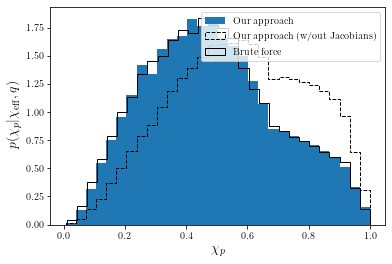

In [5]:
fig,ax = plt.subplots()
ax.hist(Xp_draws,density=True,bins=30,weights=jacobian_weights,label='Our approach')
ax.hist(Xp_draws,density=True,bins=30,histtype='step',ls='--',color='black',label='Our approach (w/out Jacobians)')
ax.hist(chi_p(test_a1s,test_a2s,test_cost1s,test_cost2s,q),density=True,histtype='step',bins=30,color='black',
       label='Brute force')
plt.legend()
ax.set_xlabel(r'$\chi_p$',fontsize=14)
ax.set_ylabel(r'$p(\chi_p|\chi_\mathrm{eff},q)$',fontsize=14)
plt.show()

We could stop here, KDE our (appropriately weighted) draws, and evaluate the KDE at a $\chi_p$ of interest. We want to be a bit more careful with the end points, though. If we KDE directly, some of our probability will leak out past our boundaries at $\chi_p = 0$ and $\chi_p = 1$.

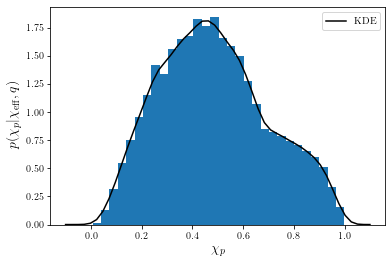

In [6]:
demo_kde = gaussian_kde(Xp_draws,weights=jacobian_weights)

fig,ax = plt.subplots()
ax.hist(Xp_draws,density=True,bins=30,weights=jacobian_weights)
ax.plot(np.linspace(-0.1,1.1,50),demo_kde(np.linspace(-0.1,1.1,50)),color='black',label='KDE')
plt.legend()
ax.set_xlabel(r'$\chi_p$',fontsize=14)
ax.set_ylabel(r'$p(\chi_p|\chi_\mathrm{eff},q)$',fontsize=14)
plt.show()

Even if we truncate to the interval $0 \leq \chi_p \leq 1$, we will still generically  end up in a situation where our prior does not go to zero at $\chi_p = 0$ and $\chi_p = 1$:

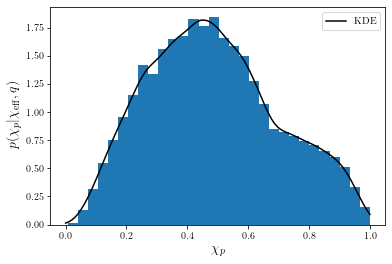

In [7]:
# Integrate across (0,1) to obtain appropriate normalization
truncated_grid = np.linspace(0,1,100)
norm_constant = np.trapz(demo_kde(truncated_grid),truncated_grid)

fig,ax = plt.subplots()
ax.hist(Xp_draws,density=True,bins=30,weights=jacobian_weights)
ax.plot(truncated_grid,demo_kde(truncated_grid)/norm_constant,color='black',label='KDE')
plt.legend()
ax.set_xlabel(r'$\chi_p$',fontsize=14)
ax.set_ylabel(r'$p(\chi_p|\chi_\mathrm{eff},q)$',fontsize=14)
plt.show()

Instead, we will take a two step approach. First, use a KDE to evaluate $p(\chi_p|\chi_\mathrm{eff},q)$ across a grid of points well inside the boundaries at $0$ and $\mathrm{Max}(\chi_p)$. Then manually specificy the endpoints, with $p(\chi_p|\chi_\mathrm{eff},q) = 0$.

Note that the maximum value of $\chi_p$ given some $\chi_\mathrm{eff}$ is

\begin{equation}
\begin{aligned}
\mathrm{Max}(\chi_p) &= \mathrm{Max}\left[\mathrm{max}\left( s_{1p}, \frac{3+4q}{4+3q} q s_{2p}\right)\right] \\
&= \mathrm{Max}(s_{1p}),
\end{aligned}
\end{equation}

defining $s_p = a \sin t$ as the in-plane spin component. If we define $s_z = a \cos t$, then

\begin{equation}
\begin{aligned}
\mathrm{Max}(\chi_p)
&= \mathrm{Max}\sqrt{a^2_\mathrm{max}-s_{1z}^2} \\
&= \sqrt{a^2_\mathrm{max}-\mathrm{Min}(s_{1z}^2)} \\
&= \sqrt{a^2_\mathrm{max}-\mathrm{Min}\left[\left((1+q)\chi_\mathrm{eff} - q s_{2z}\right)^2\right]}
\end{aligned}
\end{equation}

where the minimum is taken over possible $s_{2z}$. If $(1+q)\chi_\mathrm{eff} \leq a_\mathrm{max} q$, then there is always some $s_{2z}$ available such that the bracketed term is zero, giving $\mathrm{Max}(\chi_p) = a_\mathrm{max}$. If, on the other hand, $(1+q)\chi_\mathrm{eff} > a_\mathrm{max} q$ then the bracketed term will necessarily always be non-zero, with its smallest value occurring at $s_{2z} = a_\mathrm{max}$. In this case, $\mathrm{Max}(\chi_p) = \sqrt{a^2_\mathrm{max}-\left((1+q)\chi_\mathrm{eff} - a_\mathrm{max} q\right)^2}$.

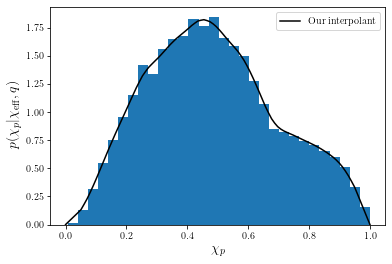

In [8]:
# Compute maximum chi_p
if (1.+q)*np.abs(Xeff)/q<aMax:
    max_Xp = aMax
else:
    max_Xp = np.sqrt(aMax**2 - ((1.+q)*np.abs(Xeff)-q)**2.)

# Set up a grid slightly inside (0,max chi_p) and evaluate KDE
reference_grid = np.linspace(0.05*max_Xp,0.95*max_Xp,50)
reference_vals = demo_kde(reference_grid)

# Manually prepend/append zeros at the boundaries
reference_grid = np.concatenate([[0],reference_grid,[max_Xp]])
reference_vals = np.concatenate([[0],reference_vals,[0]])
norm_constant = np.trapz(reference_vals,reference_grid)

# Interpolate!
prior_vals = [np.interp(Xp,reference_grid,reference_vals) for Xp in truncated_grid]

fig,ax = plt.subplots()
ax.hist(Xp_draws,density=True,bins=30,weights=jacobian_weights)
ax.plot(truncated_grid,prior_vals/norm_constant,color='black',label='Our interpolant')
plt.legend()
ax.set_xlabel(r'$\chi_p$',fontsize=14)
ax.set_ylabel(r'$p(\chi_p|\chi_\mathrm{eff},q)$',fontsize=14)
plt.show()

This procedure is implemented in the function `chi_p_prior_given_chi_eff_q` appearing in `priors.py`.  For completeness, let's compare the output of this function against the result we got in this notebook.

In [11]:
from priors import *
priors_from_function = [chi_p_prior_given_chi_eff_q(q,aMax,Xeff,xp,ndraws=30000) for xp in reference_grid]

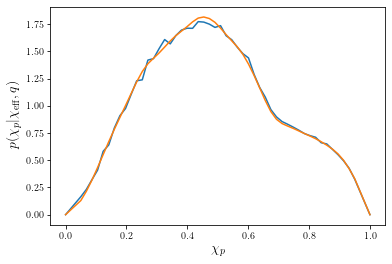

In [13]:
fig,ax = plt.subplots()
ax.plot(reference_grid,priors_from_function)
ax.plot(reference_grid,reference_vals)
ax.set_xlabel(r'$\chi_p$',fontsize=14)
ax.set_ylabel(r'$p(\chi_p|\chi_\mathrm{eff},q)$',fontsize=14)
plt.show()